<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#libraries-and-widgets" data-toc-modified-id="libraries-and-widgets-0.0.0.1"><span class="toc-item-num">0.0.0.1&nbsp;&nbsp;</span>libraries and widgets</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Neuromatch-Academy-Project---Steinmetz-Dataset---Mouse-Mind-Reading" data-toc-modified-id="Neuromatch-Academy-Project---Steinmetz-Dataset---Mouse-Mind-Reading-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Neuromatch Academy Project - Steinmetz Dataset - Mouse Mind Reading</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#explore-dictionary-for-session" data-toc-modified-id="explore-dictionary-for-session-1.0.0.1"><span class="toc-item-num">1.0.0.1&nbsp;&nbsp;</span>explore dictionary for session</a></span></li></ul></li></ul></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load Data</a></span><ul class="toc-item"><li><span><a href="#via-google-drive-directly" data-toc-modified-id="via-google-drive-directly-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>via google drive directly</a></span></li><li><span><a href="#cleanup-channel-infos" data-toc-modified-id="cleanup-channel-infos-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>cleanup channel infos</a></span></li><li><span><a href="#cleaning-up-spikes" data-toc-modified-id="cleaning-up-spikes-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>cleaning up spikes</a></span></li><li><span><a href="#cleanup-trial-info" data-toc-modified-id="cleanup-trial-info-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>cleanup trial info</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import qgrid
import requests
import hashlib
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

#from nma_class import NMA_project
from nma_class import loader


%matplotlib inline

In [2]:
#Helper functions taken from the tutorial

def plot_weights(models, sharey=True):
    """Draw a stem plot of weights for each model in models dict."""
    n = len(models)
    f = plt.figure(figsize=(10, 2.5 * n))
    axs = f.subplots(n, sharex=True, sharey=sharey)
    axs = np.atleast_1d(axs)
    for ax, (title, model) in zip(axs, models.items()):
        ax.margins(x=.02)
        stem = ax.stem(model.coef_.squeeze(), use_line_collection=True)
        stem[0].set_marker(".")
        stem[0].set_color(".2")
        stem[1].set_linewidths(.5)
        stem[1].set_color(".2")
        stem[2].set_visible(False)
        ax.axhline(0, color="C3", lw=3)
        ax.set(ylabel="Weight", title=title)
    ax.set(xlabel="Neuron (a.k.a. feature)")
    f.tight_layout()


def plot_function(f, name, var, points=(-10, 10)):
    """Evaluate f() on linear space between points and plot.

    Args:
      f (callable): function that maps scalar -> scalar
      name (string): Function name for axis labels
      var (string): Variable name for axis labels.
      points (tuple): Args for np.linspace to create eval grid.
    """
    x = np.linspace(*points)
    ax = plt.figure().subplots()
    ax.plot(x, f(x))
    ax.set(
      xlabel=f'${var}$',
      ylabel=f'${name}({var})$'
    )

def plot_model_selection(C_values, accuracies):
    """Plot the accuracy curve over log-spaced C values."""
    ax = plt.figure().subplots()
    ax.set_xscale("log")
    ax.plot(C_values, accuracies, marker="o")
    best_C = C_values[np.argmax(accuracies)]
    ax.set(
      xticks=C_values,
      xlabel="$C$",
      ylabel="Cross-validated accuracy",
      title=f"Best C: {best_C:1g} ({np.max(accuracies):.2%})",
    )

def plot_non_zero_coefs(C_values, non_zero_l1, n_voxels):
    """Plot the accuracy curve over log-spaced C values."""
    ax = plt.figure().subplots()
    ax.set_xscale("log")
    ax.plot(C_values, non_zero_l1, marker="o")
    ax.set(
    xticks=C_values,
    xlabel="$C$",
    ylabel="Number of non-zero coefficients",
    )
    ax.axhline(n_voxels, color=".1", linestyle=":")
    ax.annotate("Total\n# Neurons", (C_values[0], n_voxels * .98), va="top")

def sigmoid(z):
    return 1 / (1+np.exp(-z))

In [3]:
import matlab.engine
eng = matlab.engine.start_matlab()

#### libraries and widgets
- qgrid
- nbextentions

In [4]:
# only if you are on google coalb not if you are on jupyter notebook
#from google.colab import drive
#drive.mount('/content/gdrive')

# Neuromatch Academy Project - Steinmetz Dataset - Mouse Mind Reading

In [359]:
igood = np.array([0, 3, 4, 7, 21, 24,25,26,27,38])
good_session_folders = np.array(all_session_folders)[igood]
for i,f in enumerate(good_session_folders):
    print(i,f[38:])

0 /Cori_2016-12-14
1 /Forssmann_2017-11-01
2 /Forssmann_2017-11-02
3 /Hench_2017-06-15
4 /Muller_2017-01-07
5 /Radnitz_2017-01-08
6 /Radnitz_2017-01-09
7 /Radnitz_2017-01-10
8 /Radnitz_2017-01-11
9 /Theiler_2017-10-11


In [417]:
#idx = 17
idx = 38
igood = np.array([0, 3, 4, 7, 21, 24,25,26,27,38])

# link to parent folder with all datasets
#main_folder = "/content/gdrive/My Drive/3 Projekte/Neuromatch Summer School/Projekt/steinmetz_dataset"
#main_folder = "C:/Users/User/Google Drive/3 Projekte/Neuromatch Summer School/Projekt/steinmetz_dataset"
#main_folder = "Z:/3 Projekte/Neuromatch Summer School/Projekt/steinmetz_dataset"
main_folder = os.path.join('//Volumes','Samsung_T5','steinmetz_dataset')
code_folder = os.path.join('/Users/sam/Code/NMA','NMA_project')

# create session object
#nma_obj = NMA_project(main_folder) 

# initialize loader object
nma_obj = loader(main_folder)

# get available sessions
all_session_folders, all_session_names = nma_obj.get_available_session()
all_session_folders.sort()
good_session_folders = np.array(all_session_folders)[igood]

# default session is initialized, extract interesting dataframes in dedicated variables
#session = nma_obj.std_session

# load default session = 
session = nma_obj.load_session(all_session_folders[idx])
print(all_session_folders[idx])

#channels_df = session['channels_df']
spikes_df = session['spikes_df']
clusters_df = session['clusters_df']
trials_df = session['trials_df']


//Volumes/Samsung_T5/steinmetz_dataset/Theiler_2017-10-11


In [418]:
clusters_df.drop(clusters_df[clusters_df['label']=='bad'].index, axis=0, inplace=True)
clusters_df.head()

,label,spikes,total spikes,recording area
cluster,,,,
0,mua,"[1468.7524, 1603.5938, 1619.1727333333333, 163...",250,VISp
1,mua,"[131.64823333333334, 751.7291333333334, 1398.9...",213,VISp
2,mua,"[1502.5752, 1691.5494333333334, 1806.714233333...",131,root
5,mua,"[46.15796666666667, 416.81243333333333, 565.27...",1486,VISp
6,mua,"[1.0565666666666667, 1.9639, 2.661166666666666...",4535,SUB


In [419]:
# Filter to visual area
cluster_visual_df = clusters_df.loc[(clusters_df['recording area']=='VISa')
                                     | (clusters_df['recording area']=='VISam')
                                     | (clusters_df['recording area']=='VISI')
                                     | (clusters_df['recording area']=='VISp')
                                     | (clusters_df['recording area']=='VISpm')
                                     | (clusters_df['recording area']=='VISrl')]

In [420]:
# Filter to frontalsomatomotor area
cluster_frontalsomatomotor_df = clusters_df.loc[(clusters_df['recording area']=='RSP')
                                     | (clusters_df['recording area']=='ACA')
                                     | (clusters_df['recording area']=='MOs')
                                     | (clusters_df['recording area']=='PL')
                                     | (clusters_df['recording area']=='ILA')
                                     | (clusters_df['recording area']=='ORB')
                                     | (clusters_df['recording area']=='MOp')
                                     | (clusters_df['recording area']=='SSp')]

In [421]:
len(cl_df['spikes'])

219

In [422]:
pre_win = [-0.3,0]
post_win = [0,0.3]
cl_df = cluster_frontalsomatomotor_df
#cl_df = cluster_visual_df

perimove_rates = pd.DataFrame( {'premove spikerates':np.zeros(len(trials_df)),
                               'postmove spikerates':np.zeros(len(trials_df))}, dtype=object) 

for i,inc in enumerate(trials_df['included']):
    pre_sprs = np.empty((1,cl_df.shape[0]))[0]; pre_sprs[:] = np.nan
    post_sprs = np.empty((1,cl_df.shape[0]))[0]; post_sprs[:] = np.nan
    if inc and len(trials_df['wheel event types'][i])>0:
        #we take only those movements classified as 'real' movements, not the jitter
        ix_good_mov = trials_df['wheel event types'][i]>0
        if np.any(ix_good_mov):
            ix_earliest_good_mov = np.min(np.where(ix_good_mov))
            mov_t = trials_df['wheel event onset times'][i][ix_earliest_good_mov]
        else:
            mov_t = trials_df['stim time'][i]+0.4
        for icl,cluster_sp in enumerate(cl_df['spikes']):
            pre_spike_count = np.sum((cluster_sp>(mov_t+pre_win[0]))*(cluster_sp<(mov_t+pre_win[1])))
            pre_spike_rate = pre_spike_count/np.diff(pre_win)
            pre_sprs[icl] = pre_spike_rate
            post_spike_count = np.sum((cluster_sp>(mov_t+post_win[0]))*(cluster_sp<(mov_t+post_win[1])))
            post_spike_rate = post_spike_count/np.diff(post_win)
            post_sprs[icl] = post_spike_rate
            
    perimove_rates['premove spikerates'][i] = pre_sprs
    perimove_rates['postmove spikerates'][i] = post_sprs

In [423]:
trials_df = pd.merge(trials_df, perimove_rates, how='right', left_index=True, right_index=True)

In [424]:
#save this particular trials_df to pickle?
#trials_df.to_pickle('trials_df.p')


In [425]:
#attempt to get wheel event onsets with the provided matlab code
# itr=50
# sr = 1000
# wheelmov = trials_df['wheel movement'][itr]
# timestamp = trials_df['stim time'][itr]-0.5
# times = np.arange(timestamp,timestamp+len(wheelmov)/sr,1/sr)

# pos = matlab.double(list(wheelmov))
# t = matlab.double(list(times))
# Fs = float(sr)

# # pos : an array of wheel positions
# # t : an array of wheel sample timestamps 
# # Fs : the sampling frequency used for linear interpolation

# onsets = eng.findWheelMoves3(pos, t, Fs/10)
# print(onsets)

# plt.figure
# plt.plot(times,wheelmov)

In [426]:
#load external trials_df pickle
# trials_df = pd.read_pickle('trials_df.p')

In [427]:
#here we select the different trial types

right_go_corr = (trials_df['stim contrast right'] > trials_df['stim contrast left']) & (trials_df['response choice'] == -1)
left_go_corr = (trials_df['stim contrast right'] < trials_df['stim contrast left']) & (trials_df['response choice'] == 1)
all_go_corr = right_go_corr | left_go_corr
print(np.sum(all_go_corr))

all_nogo_corr = (trials_df['stim contrast right'] == 0) & (trials_df['stim contrast left'] == 0) & (trials_df['response choice'] == 0)
print(np.sum(all_nogo_corr))

all_corr = all_go_corr | all_nogo_corr

all_FA = (trials_df['stim contrast right'] == 0) & (trials_df['stim contrast left'] == 0) & (trials_df['response choice'] != 0)
print(np.sum(all_FA))

all_miss = (trials_df['stim contrast right'] != trials_df['stim contrast left']) & (trials_df['response choice'] == 0)
print(np.sum(all_miss))

78
100
147
10


In [428]:
#function to make the X (spikes) and Y (choices) for the logistic regression
def log_reg_prep(rates_df,idxs1,idxs0):
    spikes = np.zeros((len(np.where(idxs1 | idxs0)[0]),len(rates_df[0])))
    choices = np.zeros(len(np.where(idxs1 | idxs0)[0]))
    for i,itrial in enumerate(np.where(idxs1 | idxs0)[0]):
        spikes[i,:] = rates_df[itrial]
        if idxs1[itrial]:
            choices[i] = 1
        elif idxs0[itrial]:
            choices[i] = 0 
    spikes = np.nan_to_num(spikes)
    return spikes, choices

In [429]:
#make our X and Y for the logistic regression

X, y = log_reg_prep(trials_df['premove spikerates'],right_go_corr,all_nogo_corr) 
X_test, y_test = log_reg_prep(trials_df['premove spikerates'],all_FA,all_miss)

X2, _ = log_reg_prep(trials_df['postmove spikerates'],right_go_corr,all_nogo_corr) 
X2_test, y2_test = log_reg_prep(trials_df['postmove spikerates'],all_FA,all_miss)

ixs = np.arange(X.shape[0])
np.random.shuffle(ixs)
Xshuff = X[ixs,:]

print(X.shape,y.shape,X_test.shape,y_test.shape,Xshuff.shape)

(143, 615) (143,) (157, 615) (157,) (143, 615)


# fit logistic regression models

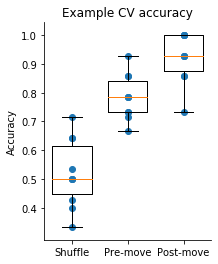

In [430]:
#get accuracy of a l2-regularized model on a k-fold cross validated set

k=10 #choose k-fold
reg = 'l2' #choose regularization. 'none', 'l1', or 'l2'
lam = 1 #choose lambda for regularizer

#fit model
accuracies = []
Ys = [y,y,y]
for i,x in enumerate(zip([Xshuff,X,X2])):
    log_reg = LogisticRegression(penalty=reg, C=1/lam, solver='lbfgs', max_iter=2000).fit(x[0], Ys[i])
    #get cross-validated accuracies
    accuracies.append(cross_val_score(log_reg, x[0], Ys[i], cv=k))

#plot the resulting accuracies
f, ax = plt.subplots(figsize=(3, 4))
ax.boxplot(accuracies, vert=True, widths=.7)
ax.scatter(np.multiply(np.ones_like(accuracies),np.array([1,2,3])[:,np.newaxis]),accuracies)
ax.set(ylabel="Accuracy",xticks=[1,2,3],xticklabels={'Shuffle','Pre-move','Post-move'},yticks=np.arange(0.4,1.1,0.1))
ax.spines["left"].set_visible(False)
seaborn.despine()

plt.title('Example CV accuracy')

plt.savefig(os.path.join(code_folder,'figs','log_reg_accuracy_example_MOTr.svg'))
plt.savefig(os.path.join(code_folder,'figs','log_reg_accuracy_example_MOTr.png'),dpi=300)

plt.show()

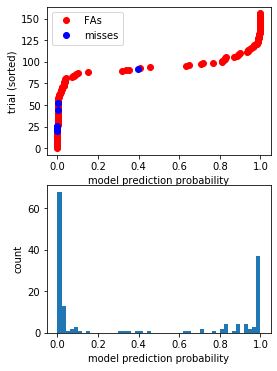

In [432]:
Xtrain = X2
Xs = X2_test
ys = y2_test

log_reg = LogisticRegression(penalty=reg, C=1/lam, solver='lbfgs', max_iter=2000).fit(Xtrain, y)


isort = np.argsort(log_reg.predict_proba(Xs)[:,1])
probas_sorted = log_reg.predict_proba(Xs)[isort,1]
y_sorted = ys[isort]

i_sorted = np.arange(len(y_sorted))

plt.figure(figsize=(4,6))

plt.subplot(2,1,1)
plt.plot(probas_sorted[np.where(y_sorted)],i_sorted[np.where(y_sorted)],'ro',label='FAs')
plt.plot(probas_sorted[np.where(y_sorted-1)],i_sorted[np.where(y_sorted-1)],'bo',label='misses')
plt.xlabel('model prediction probability')
plt.ylabel('trial (sorted)')
plt.legend()

plt.subplot(2,1,2)
plt.hist(probas_sorted,bins=50)
plt.xlabel('model prediction probability')
plt.ylabel('count')


plt.savefig(os.path.join(code_folder,'figs','log_reg_test_post_example_MOTr.svg'))
plt.savefig(os.path.join(code_folder,'figs','log_reg_test_post_example_MOTr.png'),dpi=300)

plt.show()

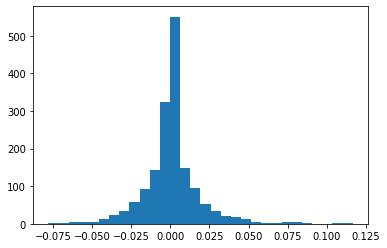

In [142]:
plt.figure(figsize=(6,4))
plt.hist(log_reg.coef_[0],bins=30)
plt.show()


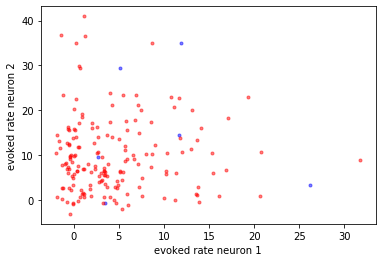

In [317]:
in1 = np.argmax(log_reg.coef_[0])
in2 = np.argmin(log_reg.coef_[0])

Xs = X
preds = log_reg.predict(Xs)

plt.figure()
plt.plot(Xs[preds==1,in1]+np.random.randn(np.sum(preds==1)),Xs[preds==1,in2]+np.random.randn(np.sum(preds==1)),'b.',alpha=.5,label='Resp')
plt.plot(Xs[preds==0,in1]+np.random.randn(np.sum(preds==0)),Xs[preds==0,in2]+np.random.randn(np.sum(preds==0)),'r.',alpha=.5,label='No Resp')
plt.xlabel('evoked rate neuron 1')
plt.ylabel('evoked rate neuron 2')
plt.show()

#### explore dictionary for session
- each ession is a dictionary
- each element kontains eather a numpy array or a dataframe
- the most important dataframes we are going to work with are:
    - clusters_df: all the spikes and clusters
    - trials_df: all the behaviour data for all trials

In [ ]:
for key, value in nma_obj.std_session.items():
    print(key, value.shape)

In [ ]:
qgrid.show_grid(channels_df)

In [ ]:
qgrid.show_grid(clusters_df)

In [ ]:
qgrid.show_grid(trials_df)

### cleanup channel infos

In [ ]:
# load channel brain location infos
brain = pd.DataFrame(session['channels_brainLocation'])
# load channel probes
site = pd.DataFrame(session['channels_sitePositions'], columns=['channel 0', 'channel 1'])
# merge with channles_df
channels_df = pd.merge(brain, site, how='inner', left_index=True, right_index=True)
# load probe, row and site
meta = pd.DataFrame({'probe':session['channels_probe'][:,0],
                            'raw row':session['channels_rawRow'][:,0],
                            'channels_site':session['channels_site'][:,0] })
# merge metha with channel_df
channels_df = pd.merge(channels_df, meta, how='inner', left_index=True, right_index=True)

In [ ]:
qgrid.show_grid(channels_df)

### cleaning up spikes

In [ ]:
# create spike_df tataframe, with each spike time and the cluster it belongs to
spikes_df = pd.DataFrame( { 'cluster':session['spikes_clusters'][:,0], 'spike_times': session['spikes_times'][:,0] }, ) 
qgrid.show_grid(spikes_df)

In [ ]:
# create cluster dataframe information and spikes for each cluster
clusters = np.unique(session['spikes_clusters'])
# create number of spikes, phy2 manual cluster, 
# parse phy annotation
clusters_df = pd.DataFrame({'lable':session['clusters__phy_annotation'][:,0], 'probe':session['clusters_probes'][:,0], 'peak channel':session['clusters_peakChannel'][:,0]}, index=clusters )
# pars labels in strings 1 = good 3 = mua
#clusters_df['lable'] = clusters_df['lable'].apply( lambda lable: 'good' if lable==3 else ('mua' if lable==1 else 'bad') )

# create spikes colum with spiketimes
spk = pd.DataFrame( {'spikes':np.zeros(len(clusters), dtype=object)}, index=clusters )
for group, frame in spikes_df.groupby('cluster'):
    spk['spikes'][group] = frame['spike_times'].values

#merge spike column with clusters_df
clusters_df = pd.merge(clusters_df, spk, how='right', left_index=True, right_index=True)
# set index name
clusters_df.index.name='cluster'
# number of spikes per cluster
clusters_df['total spikes'] = clusters_df['spikes'].apply(lambda row: len(row) )

In [ ]:
qgrid.show_grid(clusters_df)

### cleanup trial info

In [ ]:
print(session['trials_feedbackType'].shape)
print(session['trials_feedback_times'].shape)
print(session['trials_goCue_times'].shape)
print(session['trials_included'].shape)
print(session['trials_intervals'].shape)
print(session['trials_repNum'].shape)
print(session['trials_response_choice'].shape)
print(session['trials_response_times'].shape)
print(session['trials_visualStim_contrastLeft'].shape)
print(session['trials_visualStim_contrastRight'].shape)
print(session['trials_visualStim_times'].shape)

In [ ]:
# create trials dataframe
trials_df = pd.DataFrame({'included':session['trials_included'][:,0],
                          'repetition number':session['trials_repNum'][:,0],
                          # times of events
                          'go cue':session['trials_goCue_times'][:,0],
                          'stim time':session['trials_visualStim_times'][:,0],
                          'response time':session['trials_response_times'][:,0],
                          'feedback time':session['trials_feedback_times'][:,0],
                          
                          #'intervals':session['trials_intervals'][:,0], # same as go cue
                          
                          
                          'go cue':session['trials_intervals'][:,0],
                          
                          'stim contrast left':session['trials_visualStim_contrastLeft'][:,0],
                          'stim contrast right':session['trials_visualStim_contrastRight'][:,0],
                          
                          'response choice':session['trials_response_choice'][:,0],
                          'response time':session['trials_response_times'][:,0],
                          'feedback type':session['trials_feedbackType'][:,0],
                          
                         })

In [ ]:
trials_df

In [ ]:
trialT = trials_df['go cue'][0]
print(trialT)

In [ ]:
1126/binsize

In [ ]:
#Compute wheel movements
#[onsets, offsets, displacement, peakVelTimes, peakAmps] = findWheelMoves3(pos, t, Fs, varargin)
wheelpos = session['wheel_position']

trialnr = 0
binsize = 0.01
twin = [-0.5,1]

trialT = trials_df['go cue'][trialnr]

tridx = int(trialT/binsize)
t = np.arange(trialT+twin[0],trialT+twin[1],binsize)
pos = wheelpos[tridx+int(twin[0]/binsize):tridx+int(twin[1]/binsize)]
Fs = 1/binsize

onsets,offsets,displacement,peakVelTimes,peakAmps = eng.findWheelMoves3(pos,t,Fs)

In [ ]:
qgrid.show_grid(trials_df)

In [ ]:
# add wheelmovement
print(session['wheel_position'].shape)
print(session['wheel_timestamps'].shape)
print(session['wheelMoves_intervals'].shape)
print(session['wheelMoves_type'].shape)

In [ ]:
wheel_df = pd.merge( pd.DataFrame(session['wheelMoves_intervals']), pd.DataFrame(session['wheelMoves_type']), how='left', left_index=True, right_index=True)

In [ ]:
plt.figure
wheelpos = session['wheel_position']
plt.plot(wheelpos)

In [ ]:
qgrid.show_grid(pd.DataFrame(wheel_df))